In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fftshift, ifftn, fft
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
import unittest
from eolelib import *
import pandas as pd
from scipy.signal import welch
import matplotlib.cm as cm
import matplotlib.lines as mlines

In [5]:
# Parameters based on your assignment
U = 10  # Transport velocity in m/s
Lx = 6000 #Lx = 6000  # Length of the domain in the x-direction (600s * 10ms/s = 6000 m)
Ly = 384   # Width in the y-direction (384 m)
Lz = 384   # Height in the z-direction (384 m)
Nx = 8192 #Nx = 8192  # Number of grid points in x-direction
Ny = 128    # Number of grid points in y-direction
Nz = Ny   # Number of grid points in z-direction
L = 35.4   # Integral length scale in meters

a = 1/3 # Maximum theoretical value according (ABB, 2011)
Ct = 4. * (1 - a)*a

TI = 0.1 # Turbulence Intensity

rho = 1.225 # Air density in kg/m3

T = Lx / (Nx * U) #Time period

turbine_parameters = [
    {
        "z_hub" : 100,
        "R_rotor" : 100/2,
        "K" : 1.5e5,
        "M" : 2.5e6,
        "c" : "#333333"
    },
    {
        "z_hub" : 150,
        "R_rotor" : 200/2,
        "K" : 6.5e5,
        "M" : 2.0e6,
        "c" : "#CC0000"
    },
    {
        "z_hub" : 200,
        "R_rotor" : 300/2,
        "K" : 1.9e6,
        "M" : 1.8e6,
        "c" : "#0057B7"
    }
]

## Generation of the climatic model

In [6]:
##Generate turbulence and rescale to fit the wanted turbulence intensity TI

# Generate the turbulent velocity fields
u_turb, v_turb, w_turb = VonKarmanTurbulenceField(Lx, Ly, Lz, Nx, Ny, Nz, L)

#Rescale of u_turb
u_turb = u_turb * (TI*U / u_turb.std())

U_turb = [u_turb, v_turb, w_turb]

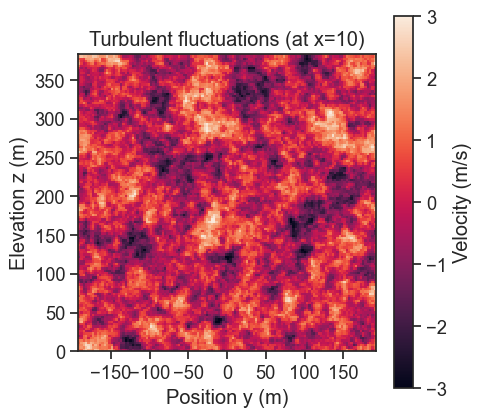

In [7]:
_time = 10

# Apply seaborn's theme and color palette
sns.set(style="ticks", palette="deep", font_scale=1.2)

plt.matshow(u_turb[:,:,_time], extent=[-Ly/2, Ly/2, 0, Lz], vmin=-3, vmax=3)
plt.colorbar(label="Velocity (m/s)")
plt.title(f"Turbulent fluctuations (at x={_time})")
plt.xlabel("Position y (m)")
plt.ylabel("Elevation z (m)")
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
plt.savefig(f"./fig/fig_turbulentfield_t={_time}.svg", bbox_inches='tight')
plt.savefig(f"./fig/fig_turbulentfield_t={_time}.png", bbox_inches='tight')

In [8]:
##Calculate the boundary layer wind
u_turb_bak = u_turb.copy()
for i in range(Nz):
    u_turb[:,i,:] =  u_turb[:,i,:] + UShear(z = i/Nz*Lz, u_inf=U)

TI = \frac{STD(U_turn)}{U}

C:\Users\louis\AppData\Local\Temp\ipykernel_10528\3738297897.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # Adjust for space on the right for the colorbar


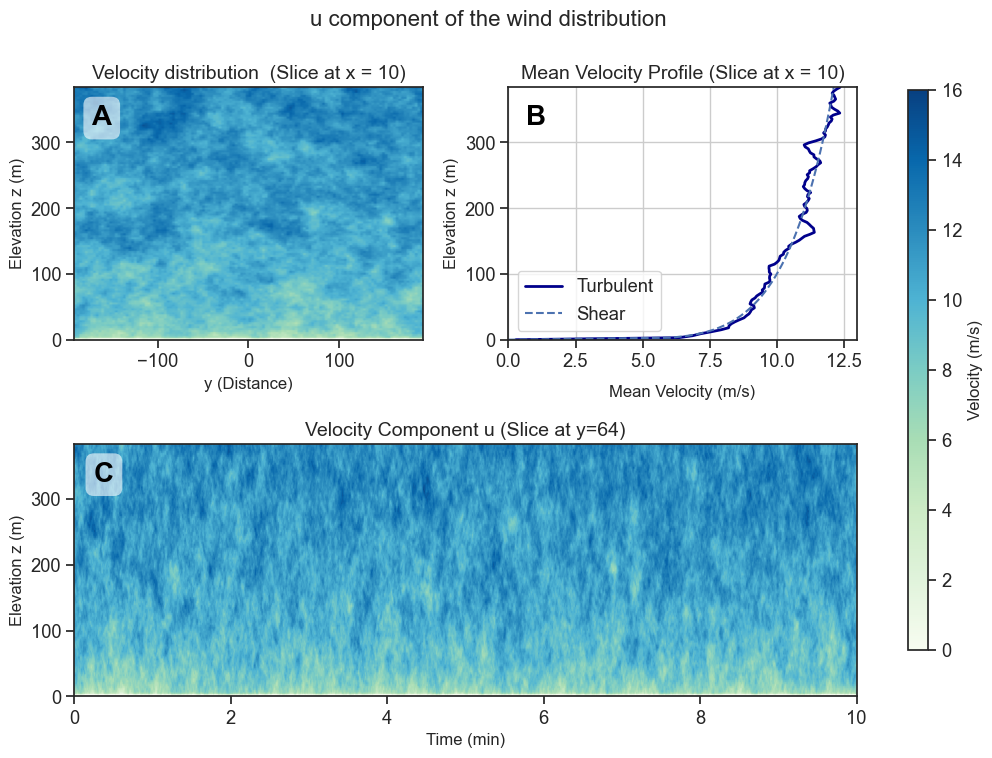

In [18]:
time = 10

# Apply seaborn's theme and color palette
sns.set(style="ticks", palette="deep", font_scale=1.2)

# Creating the figure with 3 rows, the third one spanning both columns
fig = plt.figure(figsize=(10, 8))

# Main title for the entire figure
fig.suptitle("u component of the wind distribution", y=0.95, fontsize=16)

# Set the velocity range for the colorbar
vmin, vmax = 0, 16

# First plot: Velocity distribution (top left)
ax1 = plt.subplot2grid((2, 2), (0, 0))
im1 = ax1.imshow(u_turb[:, ::-1, time].T, extent=[-Ly/2, Ly/2, 0, Lz], aspect='auto', cmap="GnBu", vmin=vmin, vmax=vmax)
ax1.set_title(f'Velocity distribution  (Slice at x = {time})', fontsize=14)
ax1.set_xlabel('y (Distance)', fontsize=12)
ax1.set_ylabel('Elevation z (m)', fontsize=12)
ax1.text(0.05, 0.85, "A", transform=ax1.transAxes, fontsize=20, fontweight='bold', color='black',
         bbox=dict(facecolor='white', edgecolor='none', boxstyle='round', alpha=0.6))

# Second plot: Mean velocity profile (top right)
ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(u_turb[:, :, time].mean(axis=0), np.linspace(0, Lz, Nz), color="darkblue", linewidth=2, label="Turbulent")
ax2.plot(UShear(np.linspace(0, Lz, Nz), u_inf=U), np.linspace(0, Lz, Nz), "--", label="Shear")
ax2.legend()
ax2.set_title(f'Mean Velocity Profile (Slice at x = {time})', fontsize=14)
ax2.set_xlabel('Mean Velocity (m/s)', labelpad=10, fontsize=12)
ax2.set_ylabel('Elevation z (m)', fontsize=12)
ax2.set_ylim(0, Lz)
ax2.set_xlim(0)
ax2.grid(True)
ax2.text(0.05, 0.85, "B", transform=ax2.transAxes, fontsize=20, fontweight='bold', color='black',
         bbox=dict(facecolor='white', edgecolor='none', boxstyle='round', alpha=0.6))

# Third plot: Full-width plot in the bottom row spanning both columns
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
y_pos = int(Ny / 2)
im2 = ax3.imshow(u_turb[y_pos, ::-1, :], aspect='auto', extent=[0, Lx/U /60, 0, Lz], cmap="GnBu", vmin=vmin, vmax=vmax)
ax3.set_title(f'Velocity Component u (Slice at y={y_pos})', fontsize=14)
ax3.set_xlabel('Time (min)', fontsize=12)
ax3.set_ylabel('Elevation z (m)', fontsize=12)
ax3.text(0.025, 0.85, "C", transform=ax3.transAxes, fontsize=20, fontweight='bold', color='black',
         bbox=dict(facecolor='white', edgecolor='none', boxstyle='round', alpha=0.6))

# Single colorbar for the entire figure
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Position for the color bar [left, bottom, width, height]
cbar = fig.colorbar(im1, cax=cbar_ax)
cbar.set_label("Velocity (m/s)", fontsize=12)

# Adjust layout to ensure proper spacing
plt.tight_layout(rect=[0, 0, 0.9, 0.96])  # Adjust for space on the right for the colorbar

plt.savefig(f"./fig/fig_combined_turbulentfield_x={_time}&y={y_pos}.svg", bbox_inches='tight')
plt.savefig(f"./fig/fig_combined_turbulentfield_x={_time}&y={y_pos}.png", bbox_inches='tight')


## Calculation of $F_{RHS}$

In [8]:
for elem in turbine_parameters:
    F_RHS = []
    for time in range(0,Lx):
        # Corrected calculation of forcing/excitation
        def f_int(y, z, t=time):
            # Define positions relative to the rotor disk center, ensuring bounds are respected
            x_position = t
            y_position = y + Ly * 0.5  # Shift y to match [0, Ly] requirement
            z_position = z
        
            return (get_velocity(x_position, y_position, z_position, u_turb, Lx, Ly, Lz))**2
        
        # Perform integration using integration_cubature57, adjusting for radius and hub height
        F_RHS.append( Ct * 0.5 * rho * integration_cubature57(lambda y, z: f_int(y, z), elem["R_rotor"], "./weight.dat", 0, elem["z_hub"]))
    elem["F_RHS"] = np.array(F_RHS)

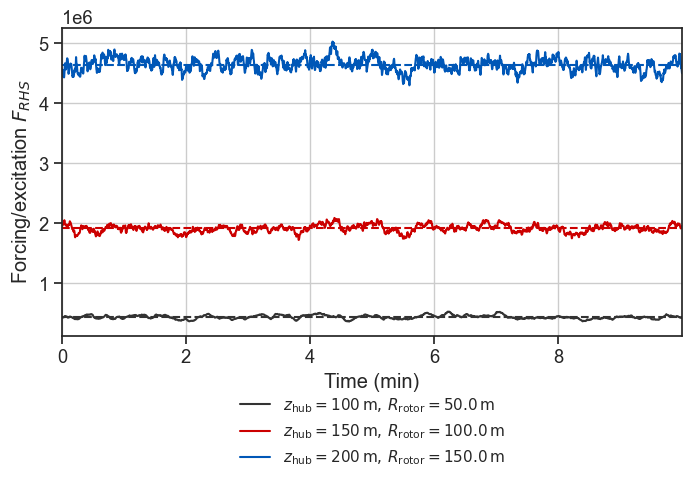

In [9]:
plt.figure(figsize=(8, 4))

# Loop through each entry and plot the FHS data with time in seconds
for idx, entry in enumerate(turbine_parameters):
    z_hub = entry['z_hub']
    R_rotor = entry['R_rotor']
    FHS = entry['F_RHS']
    
    # Calculate time in seconds for the x-axis
    time_in_min = np.arange(len(FHS)) / U / 60
    
    # Plot FHS data with LaTeX-formatted label indicating z_hub and R_rotor
    plt.plot(time_in_min, FHS, color=entry["c"], label=fr"$z_{{\text{{hub}}}}={z_hub}\,\text{{m}},\,R_{{\text{{rotor}}}}={R_rotor}\,\text{{m}}$")
    plt.plot([time_in_min[0], time_in_min[-1]], [np.mean(FHS)] * 2, linestyle='--', color=entry["c"])  # Average line with the same color

# Setting labels and formatting
plt.xlabel(r'Time (min)')
plt.ylabel(r'Forcing/excitation $F_{RHS}$')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.xlim(0, time_in_min[-1])

# Place the legend below the plot with a larger font size
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1, fontsize=11, frameon=False)

# Add grid
plt.grid(True)

plt.savefig(f"./fig/fig_timeSerie_forcing-exitation.svg", bbox_inches='tight')
plt.savefig(f"./fig/fig_timeSerie_forcing-exitation.png", bbox_inches='tight')

## Calculation of the damping constant $\gamma$

In [10]:
for elem in turbine_parameters:
    
    def f_int(y, z):
        return UShear(z)
    
    elem["gamma"] = Ct * 0.5 * rho * integration_cubature57(lambda y, z: f_int(y, z), elem["R_rotor"], "./weight.dat", 0, elem["z_hub"])

## Fourier transform of the $F_{RHS}$ : $\widehat{F_{RHS}}$

In [11]:
for elem in turbine_parameters:
    elem["F_RHS_hat"] = fft(elem["F_RHS"])
    elem["frequencies"] = np.fft.fftfreq(len(elem["F_RHS"]), T)

## Solving the problem for $\hat{x}$ in Fourrier Space

In [12]:
for elem in turbine_parameters:
    elem["omega"] = 2 * np.pi * elem["frequencies"]
    elem["H_omega"] = 1 / (-elem["omega"]**2 * elem["M"] + 1j * elem["omega"] * elem["gamma"] + elem["K"])
    elem["x_hat"] = elem["H_omega"] * elem["F_RHS_hat"]
    
    elem["x_temporal"] = np.fft.ifft(elem["x_hat"])

C:\Users\louis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\louis\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


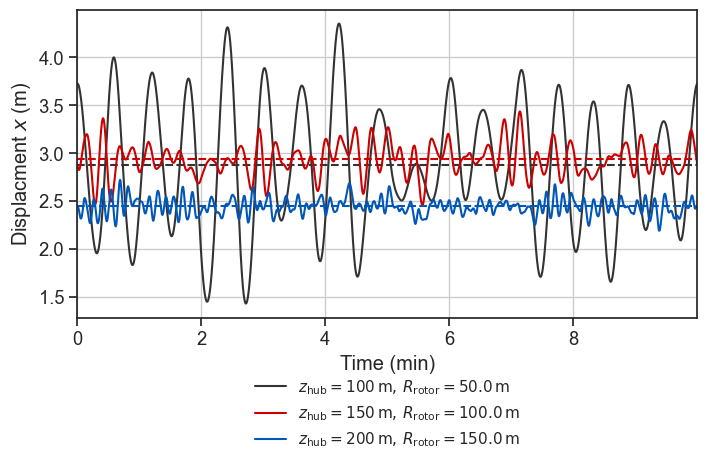

In [13]:
plt.figure(figsize=(8, 4))

# Loop through each entry and plot the FHS data with time in seconds
for idx, entry in enumerate(turbine_parameters):
    z_hub = entry['z_hub']
    R_rotor = entry['R_rotor']
    x_temporel = entry['x_temporal']
    
    # Calculate time in seconds for the x-axis
    time_in_min = np.arange(len(x_temporel)) / U / 60
    
    # Plot FHS data with LaTeX-formatted label indicating z_hub and R_rotor
    plt.plot(time_in_min, x_temporel, color=entry["c"], label=fr"$z_{{\text{{hub}}}}={z_hub}\,\text{{m}},\,R_{{\text{{rotor}}}}={R_rotor}\,\text{{m}}$")
    plt.plot([time_in_min[0], time_in_min[-1]], [np.mean(x_temporel)] * 2, linestyle='--', color=entry["c"])  # Average line with the same color

# Setting labels and formatting
plt.xlabel(r'Time (min)')
plt.ylabel(r'Displacment $x$ (m)')
plt.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
plt.xlim(0, time_in_min[-1])

# Place the legend below the plot with a larger font size
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=1, fontsize=11, frameon=False)

# Add grid
plt.grid(True)

plt.savefig(f"./fig/fig_timeSerie_displacment.svg", bbox_inches='tight')
plt.savefig(f"./fig/fig_timeSerie_displacment.png", bbox_inches='tight')

### Evaluation impact imaginary part

In [14]:
# List to store results for each record
results = []

# Calculations for each record
for record in turbine_parameters:
    z_hub = record['z_hub']
    R_rotor = record['R_rotor']
    x_temporal = record['x_temporal']
    
    r_mean = (np.real(x_temporal) / np.abs(x_temporal)).mean()
    r_std = (np.real(x_temporal) / np.abs(x_temporal)).std()
    i_mean = (np.imag(x_temporal) / np.abs(x_temporal)).mean()
    i_std = (np.imag(x_temporal) / np.abs(x_temporal)).std()
    
    # Append results with turbine parameters
    results.append({
        "Hub Height (z_hub)": z_hub,
        "Rotor Radius (R_rotor)": R_rotor,
        "Real Part Mean": f"{r_mean:.2e}",
        "Real Part Std": f"{r_std:.2e}",
        "Imaginary Part Mean": f"{i_mean:.2e}",
        "Imaginary Part Std": f"{i_std:.2e}"
    })

# Convert results to a DataFrame for display and export
df_results = pd.DataFrame(results)

# Save DataFrame as a LaTeX table
with open("./fig/turbine_parameter_contributions_with_radius.tex", "w") as f:
    f.write(df_results.to_latex(index=False))

df_results

,Hub Height (z_hub),Rotor Radius (R_rotor),Real Part Mean,Real Part Std,Imaginary Part Mean,Imaginary Part Std
0,100,50.0,1.00e+00,0.00e+00,3.94e-19,5.49e-14
1,150,100.0,1.00e+00,0.00e+00,8.58e-20,4.10e-14
2,200,150.0,1.00e+00,0.00e+00,4.68e-20,7.93e-12


### Evaluation of the neglected terms

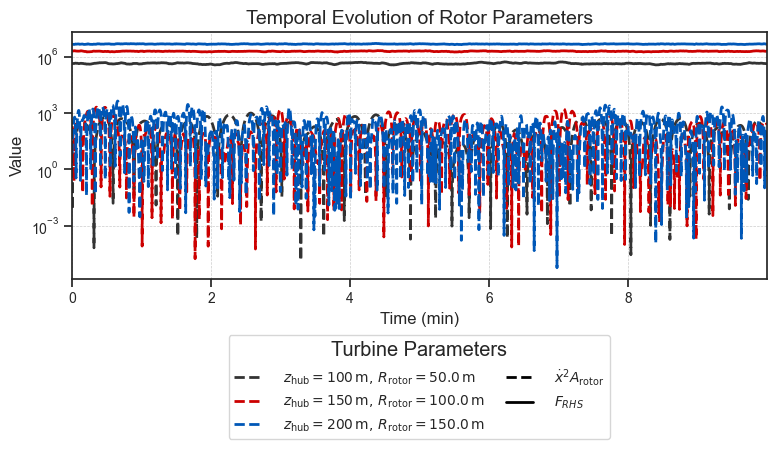

In [15]:

# Define a color map for turbine instances
num_turbines = len(turbine_parameters)

plt.figure(figsize=(8, 5))

# Track labels to only add unique entries to the legend
turbine_labels = []

for idx, record in enumerate(turbine_parameters):
    dx_dt = np.gradient(np.real(record["x_temporal"]), T)
    
    # Unique label for each turbine instance with its parameters
    turbine_label = fr"$z_{{\text{{hub}}}}={record['z_hub']}\,\text{{m}},\,R_{{\text{{rotor}}}}={record['R_rotor']}\,\text{{m}}$"
    
    # Plot dx_dt^2 * A_rotor^2 with dashed line for this turbine
    plt.plot(
        time_in_min,
        dx_dt**2 * np.pi * record["R_rotor"]**2,
        label=turbine_label if turbine_label not in turbine_labels else None,  # Add label once
        linewidth=2,
        linestyle="--",
        color=record["c"]
    )
    
    # Plot F_RHS with a solid line for this turbine
    plt.plot(
        time_in_min,
        record["F_RHS"],
        label=None,  # Exclude label to avoid duplicating in legend
        linewidth=2,
        linestyle="-",
        color=record["c"]
    )
    
    turbine_labels.append(turbine_label)

# Creating custom legend entries for line styles
dx_dt_line = mlines.Line2D([], [], color='black', linestyle='--', linewidth=2, label=r'$\dot{x}^2 A_{\text{rotor}}$')
f_rhs_line = mlines.Line2D([], [], color='black', linestyle='-', linewidth=2, label=r'$F_{RHS}$')

# Adding custom entries to the legend
plt.legend(handles=plt.gca().get_legend_handles_labels()[0] + [dx_dt_line, f_rhs_line],
           loc="upper center", bbox_to_anchor=(0.5, -0.20), fontsize=10,
           title="Turbine Parameters", ncol=2, columnspacing=1.5, handletextpad=1.5)

plt.yscale("log")
plt.xlabel("Time (min)", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Temporal Evolution of Rotor Parameters", fontsize=14)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlim(0, time_in_min[-1])

plt.tight_layout()

plt.savefig(f"./fig/fig_timeSerie_comparaison_X2A2-Frhs.svg", bbox_inches='tight')
plt.savefig(f"./fig/fig_timeSerie_comparaison_X2A2-Frhs.png", bbox_inches='tight')

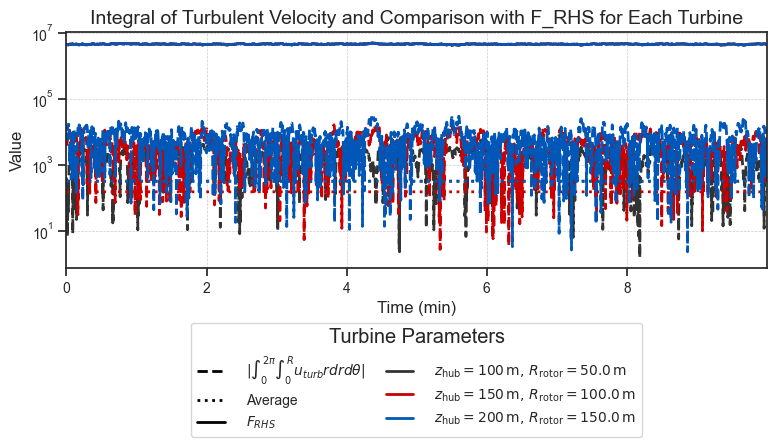

In [16]:
# Define a color map for turbine instances
num_turbines = len(turbine_parameters)

plt.figure(figsize=(8, 5))

for idx, record in enumerate(turbine_parameters):
    int_u_turb = []
    for time in range(0, Lx):
        def f_int(y, z, t=time):
            # Define positions relative to the rotor disk center, ensuring bounds are respected
            x_position = t
            y_position = y + Ly * 0.5  # Shift y to match [0, Ly] requirement
            z_position = z

            return get_velocity(x_position, y_position, z_position, u_turb_bak, Lx, Ly, Lz)
        
        int_u_turb.append(integration_cubature57(lambda y, z: f_int(y, z), record["R_rotor"], "./weight.dat", 0, record["z_hub"]))
    
    int_u_turb = np.array(int_u_turb)
    
    # Unique label for each turbine instance with its parameters
    turbine_label = fr"$z_{{\text{{hub}}}}={record['z_hub']}\,\text{{m}},\,R_{{\text{{rotor}}}}={record['R_rotor']}\,\text{{m}}$"
    
    # Plot |∫ u_turb| for this turbine
    plt.plot(
        time_in_min,
        np.abs(int_u_turb),
        label=None, # Skip label to avoid duplication in the legend
        linestyle="--",
        linewidth=2,
        color=record["c"]
    )
    
    # Plot constant average line for this turbine
    plt.plot(
        time_in_min,
        int_u_turb * 0 + int_u_turb.mean(),
        label=None,  # Exclude label to avoid duplicating in legend
        linestyle=":",
        linewidth=2,
        color=record["c"]
    )
    
    # Plot F_RHS for this turbine
    plt.plot(
        time_in_min,
        F_RHS,
        label=turbine_label,
        linestyle="-",
        linewidth=2,
        color=record["c"]
    )

# Creating custom legend entries for line styles
abs_int_line = mlines.Line2D([], [], color='black', linestyle='--', linewidth=2, label=r'$|\int_0^{2\pi} \int_0^R u_{turb}rdrd\theta|$')
avg_line = mlines.Line2D([], [], color='black', linestyle=':', linewidth=2, label='Average')
f_rhs_line = mlines.Line2D([], [], color='black', linestyle='-', linewidth=2, label=r'$F_{RHS}$')

# Adding custom entries to the legend
plt.legend(handles=[abs_int_line, avg_line, f_rhs_line] + plt.gca().get_legend_handles_labels()[0],
           loc="upper center", bbox_to_anchor=(0.5, -0.20), fontsize=10, ncol=2,
           columnspacing=1.5, handletextpad=1.5, title="Turbine Parameters")

plt.yscale("log")
plt.xlabel("Time (min)", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.title("Integral of Turbulent Velocity and Comparison with F_RHS for Each Turbine", fontsize=14)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.xlim(0, time_in_min[-1])

plt.tight_layout()

plt.savefig(f"./fig/fig_timeSerie_comparaison_intU-Frhs.svg", bbox_inches='tight')
plt.savefig(f"./fig/fig_timeSerie_comparaison_intU-Frhs.png", bbox_inches='tight')

,Hub Height (z_hub),Rotor Radius (R_rotor),Max Frequency (Hz),1/2pi * sqrt(K//M)
0,100,50.0,0.040000,0.038985
1,150,100.0,0.093333,0.090732
2,200,150.0,0.160000,0.163516


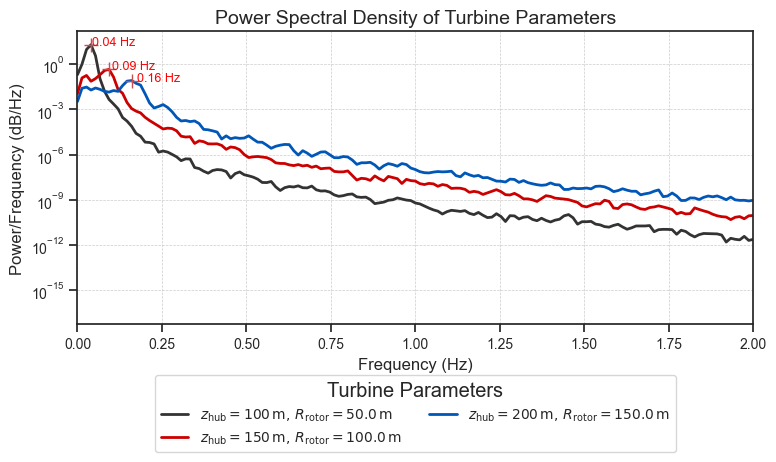

In [17]:
bak_freq = []

plt.figure(figsize=(8, 5))

for record in turbine_parameters:
    # Center x_temporal data
    x_centered = np.real(record["x_temporal"] - record["x_temporal"].mean())

    # Compute the Power Spectral Density (PSD)
    frequencies, psd = welch(x_centered, fs=1/T, nperseg=1024)
    
    # Find the maximum PSD value and its corresponding frequency
    max_psd = np.max(psd)
    max_freq = frequencies[np.argmax(psd)]

    # Unique label for each turbine instance with its parameters
    turbine_label = fr"$z_{{\text{{hub}}}}={record['z_hub']}\,\text{{m}},\,R_{{\text{{rotor}}}}={record['R_rotor']}\,\text{{m}}$"

    # Plot PSD with semilog scale
    plt.semilogy(frequencies, psd, label=turbine_label, linewidth=2, color=record["c"])

    # Mark and annotate the maximum PSD point
    plt.plot(max_freq, max_psd, 'r+', markersize=10, lw=2)
    plt.text(max_freq * 1.1, max_psd, f"{max_freq:.2f} Hz", color="red", fontsize=9)
    
    bak_freq.append({
        "Hub Height (z_hub)" : record['z_hub'],
        "Rotor Radius (R_rotor)" : record['R_rotor'],
        "Max Frequency (Hz)" : max_freq,
        "1/2pi * sqrt(K//M)" : 1/(2*np.pi) * np.sqrt(record['K'] / record['M']) 
    })

# Title and Labels
plt.title("Power Spectral Density of Turbine Parameters", fontsize=14)
plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("Power/Frequency (dB/Hz)", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.xlim(0, 2)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add legend below the plot
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), fontsize=10, ncol=2, title="Turbine Parameters")
plt.tight_layout()

plt.savefig(f"./fig/fig_PSD.svg", bbox_inches='tight')
plt.savefig(f"./fig/fig_PSD.png", bbox_inches='tight')

with open("./fig/frenquency_comparaison.tex", "w") as f:
    f.write(pd.DataFrame(bak_freq).to_latex(index=False))

pd.DataFrame(bak_freq)

In [18]:
pd.DataFrame(bak_freq)

,Hub Height (z_hub),Rotor Radius (R_rotor),Max Frequency (Hz),1/2pi * sqrt(K//M)
0,100,50.0,0.040000,0.038985
1,150,100.0,0.093333,0.090732
2,200,150.0,0.160000,0.163516


In [19]:
export_to_netcdf(turbine_parameters, "turbine_parameters.nc")